In [1]:
from clipppy import load_config
from matplotlib import pyplot as plt
import torch, pyro, numpy as np 
import collections, os
from ruamel.yaml import YAML
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pyro import distributions as dist

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *
from channels import split_channels

In [2]:
config = load_config('config_gen_mock_lens_source.yaml')

model = config.umodel
guide = config.guide 

PARAMS = YAML().load(open('params.yaml'))['lens_source']

# print(model().shape)
# print(model())

SYSTEM_NAME = "ngc4414"

SOURCE_DIR = '../../mock_data/sources'
source_name = f'{SYSTEM_NAME}.npy'

SAVE_DIR = "gen_obs"
n_channels  = model.n_channels
sigma_stat = model.stochastic_specs['sigma_stat']

# print(f'cmc = {cmc}, n_channels = {n_channels}, sigma_stat = {sigma_stat}')

/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:102: RuntimeWarning: Getting items from StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level that at most come from mappings (no dynamic generation).
  warn(f'Getting items from {type(self).__name__} by name is frowned upon'


In [3]:
def rescale(img):
    img = img - img.min()
    img = img / img.max()
    return img

def convert2rgb(img):
    shape = img.shape
    (nc, nx, ny) = tuple(shape)
    img_new = torch.zeros((nx, ny, nc))

    for i in range(nx):
        for j in range(ny):
            img_new[i,j] = img[:,i,j]
    
    return img_new

def reorder(img, indices):
    [a, b, c] = indices
    
    img_new = torch.zeros(img.shape)    
    img_new[:,:,0] = img[:,:,a]
    img_new[:,:,1] = img[:,:,b]
    img_new[:,:,2] = img[:,:,c]
    return img_new

def remove_color(img, a, b, c):
    img_new = img.clone()
    img_new[:,:,a] -= img_new[:,:,b] * c
    img_new[:,:,b] = 0
    img_new = rescale(img_new)
    return img_new

In [4]:
m = model()
cmc = [c() for c in model.cmc.values()][0]

img = m
img = rescale(img)
img = convert2rgb(img)
img = reorder(img, [1, 2, 0])
img_1 = remove_color(img, 1, 0, 1. - cmc[1])
img_2 = remove_color(img, 1, 2, cmc[1])

img_new = [t.detach().numpy() for t in [img_1, img_2, img]]

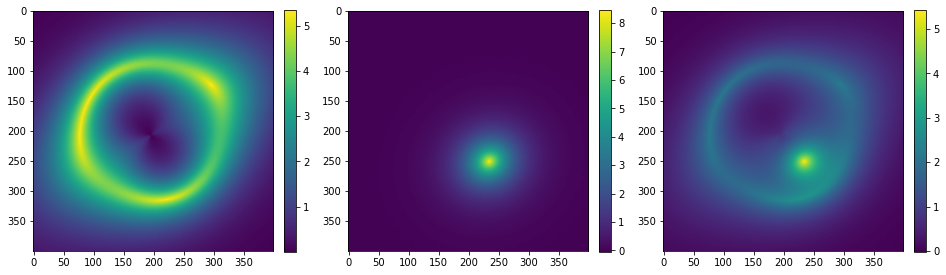

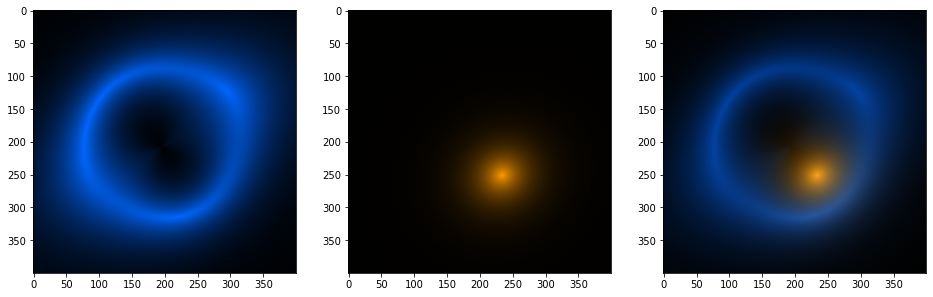

In [5]:
plot_imshow(m, colorbar = True)
plot_imshow(img_new)

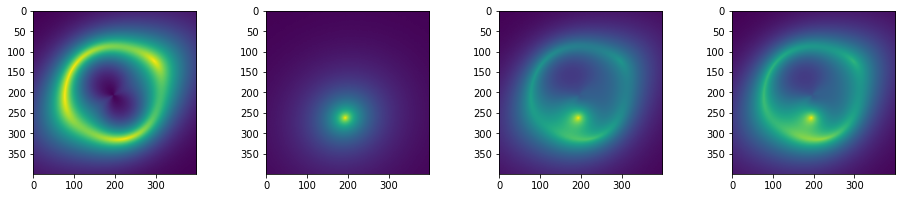

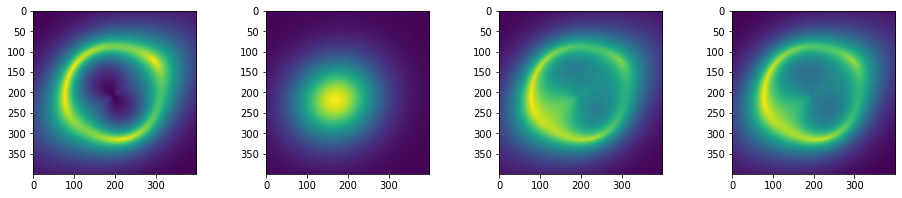

In [6]:
if n_channels >= 2:
    plot_imshow(split_channels(model()), size_y = 3)
    plot_imshow(split_channels(model()), size_y = 3)
if n_channels == 1:
    plot_imshow([model(), model()], size_y = 3)

In [7]:
with pyro.poutine.trace() as tracer, pyro.condition(data=PARAMS['truth']):
    OBS = model()
OBSTRACE = tracer.trace

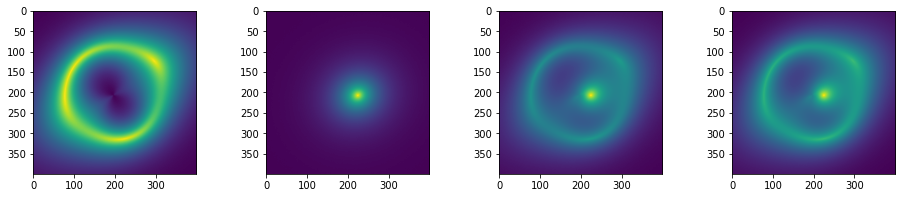

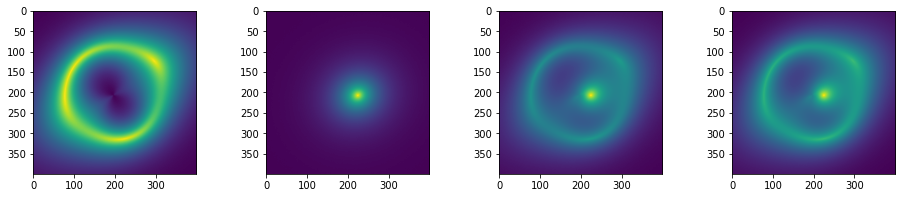

In [8]:
if n_channels >= 2:
    plot_imshow(split_channels(OBS), size_y = 3)
    plot_imshow(split_channels(OBS), size_y = 3)
if n_channels == 1:
    plot_imshow([OBS, OBS], size_y = 3)

In [10]:
keys = OBSTRACE.nodes.keys()
for k in keys: 
    print(f'{k:<15} {OBSTRACE.nodes[k]["fn"]}\n\t\t{OBSTRACE.nodes[k]["value"]}')

lenslight2/x    Uniform(low: -1.0, high: 1.0)
		0.3
lenslight2/y    Uniform(low: -1.0, high: 1.0)
		0.1
lenslight2/index Uniform(low: 0.5, high: 2.0)
		1.1
lenslight2/r_e  Uniform(low: 0.5, high: 2.0)
		0.9
lenslight2/I_e  Uniform(low: 0.5, high: 2.0)
		1.1
Xsrc            MaskedDistribution()
		tensor([[-1.5134, -1.5037, -1.4940,  ...,  1.4551,  1.4656,  1.4761],
        [-1.5106, -1.5008, -1.4911,  ...,  1.4526,  1.4631,  1.4737],
        [-1.5077, -1.4980, -1.4882,  ...,  1.4501,  1.4607,  1.4712],
        ...,
        [-1.4476, -1.4370, -1.4265,  ...,  1.4196,  1.4297,  1.4398],
        [-1.4502, -1.4397, -1.4291,  ...,  1.4225,  1.4326,  1.4427],
        [-1.4528, -1.4423, -1.4318,  ...,  1.4254,  1.4355,  1.4456]])
Ysrc            MaskedDistribution()
		tensor([[-1.5611, -1.5582, -1.5554,  ..., -1.5555, -1.5579, -1.5604],
        [-1.5508, -1.5480, -1.5451,  ..., -1.5447, -1.5471, -1.5496],
        [-1.5406, -1.5378, -1.5349,  ..., -1.5339, -1.5364, -1.5388],
        ...,
       

In [6]:
# torch.save(OBS, os.path.join(SAVE_DIR,f'mock_cmc={cmc}_sigma={sigma_stat}.pt'))
# torch.save(OBS, f'mock_cmc={cmc}_sigma={sigma_stat}.pt')
torch.save(OBS, 'gen_source_lens_source.pt')